# Beers in the USA: a prediction of State of origin based on beer tastes

## imports

In [2]:
from src.data.save_tar_gz import tar_gz_to_csv
from src.data.load_data import load_data_from_csv
from src.utils.data_utils import *
from src.data.additional_data import *
import warnings
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import src.data.wrangling as wrangling
from datetime import datetime

# NEEED TO ADD A FUNCTION CALL TO LOAD AND CLEAN DATA

## Loading the data into dict. of dataframes

This part loads the data from the specified path. There are two options. The first one is to load directly from the compressed .tar.gz files, which is needed for the first run and that will save the data files in readable .csv files. Once we have these .csv files, we can directly load from them using the second option.


### Option 1: data still in .tar.gz

In [3]:
# Use these lines for the first loading, tar.gz files must be in the data/ folder. After executing them, directly do the wrangling to save clean .csv

# warnings.filterwarnings("ignore")
# data = tar_gz_to_csv(load_path= 'data/', save_path='data/raw/', load_text = False)
# warnings.filterwarnings("default")

### Option 2: data in .csv

In [4]:
# Use this line if you have all the data extracted to wrangled csv files under data/raw in subfolders BeerAdvocate, RateBeer, and MatchedBeerData.
# It loads the data into 3 dictionnaries containing the dataframes

# data_ba, data_rb, data_matched = load_data_from_csv('data/raw/')

# print(data_ba.keys())
# print(data_rb.keys())
# print(data_matched.keys())

# #remove textual review columns if needed
# remove_txt_columns(data_ba, data_rb, data_matched)

# data_ba['BeerAdvocate_ratings.csv'].head()

### Option 3: load from clean_path

In [5]:
Ratebeer_path = lambda path: f"{path}/Ratebeer"
BeerAdvocate_path = lambda path: f"{path}/BeerAdvocate"
Matched_path = lambda path: f"{path}/MatchedBeerData"
path = "data/clean"

Ratebeer_file = lambda file: f"{Ratebeer_path(path)}/{file}"
BeerAdvocate_file = lambda file: f"{BeerAdvocate_path(path)}/{file}"
Matched_file = lambda file: f"{Matched_path(path)}/{file}"

# Tests à la con

In [6]:
def get_ba_beer_merged():
    ba_usa_ratings = pd.read_csv("data/clean/BeerAdvocate/usa_ratings.csv")
    ba_usa_users = pd.read_csv("data/clean/BeerAdvocate/usa_users.csv")

    ba_usa_ratings = ba_usa_ratings.merge(ba_usa_users[['user_id', 'location']], on='user_id', how='left')
    ba_usa_ratings['state'] = ba_usa_ratings['location'].apply(lambda x: x.split(', ')[-1])

    return ba_usa_ratings


ba_usa_ratings = get_ba_beer_merged()

In [7]:
#users_matched = data_matched['matched_beer_data_users.csv']
#users_ba = data_ba['BeerAdvocate_users.csv']
#users_rb = data_rb['RateBeer_users.csv']

# need to add column of beer rating
#ba_beers = pd.read_csv(f"{BeerAdvocate_path(clean_path)}/beers.csv")

# grouped by beer and state
column_to_group = 'style'

#ba_usa_ratings['state'] = ba_usa_ratings['location'].apply(lambda x: x.split(', ')[-1])
reviews_by_beer_state = ba_usa_ratings.groupby(['state', column_to_group]).mean(numeric_only=True).reset_index()
#reviews_by_state = ba_usa_ratings['abv', 'location'].groupby('location').mean()#.reset_index(name='review_count')
reviews_by_beer_state = reviews_by_beer_state.loc[:, ['state', column_to_group, 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']]
# to know how many got grouped
reviews_by_beer_state['review_count'] = ba_usa_ratings.groupby(['state', column_to_group]).size().values
reviews_by_beer_state = reviews_by_beer_state.loc[reviews_by_beer_state["review_count"] > 10]    # only more than 10 reviews by beer

# selected_rows = reviews_by_beer_state[reviews_by_beer_state['style'] == "English Pale Ale"]

beer_styles = pd.unique(reviews_by_beer_state[column_to_group])
print(len(beer_styles))
# selected_rows



104


## Top-Rated Beer Styles

In [8]:
#top-rated beer styles overall
top_beer_styles = reviews_by_beer_state.groupby('style')['overall'].mean().sort_values(ascending=False)
print("Top-rated beer styles across the U.S.:")
print(top_beer_styles.head(10))

#top-rated beer style per state
top_beer_styles_by_state = reviews_by_beer_state.loc[reviews_by_beer_state.groupby('state')['overall'].idxmax()]
print("Top-rated beer styles by state:")
print(top_beer_styles_by_state[['state', 'style', 'overall']])




Top-rated beer styles across the U.S.:
style
Gose                                2.974140
Kvass                               2.867680
Eisbock                             2.702948
Berliner Weissbier                  2.642580
American Wild Ale                   2.590513
English Pale Mild Ale               2.578963
American Double / Imperial Stout    2.568663
Baltic Porter                       2.564610
Weizenbock                          2.561228
Roggenbier                          2.546682
Name: overall, dtype: float64
Top-rated beer styles by state:
               state                      style   overall
8            Alabama    American Dark Wheat Ale  2.819444
148           Alaska      English Dark Mild Ale  4.154762
239          Arizona                    Braggot  3.444444
352         Arkansas                    Eisbock  3.521739
475       California                       Gose  2.750821
558         Colorado                    Eisbock  3.062925
683      Connecticut                 

## Diversity in Preferences

Beer styles with the highest variance in ratings across states:
style
Happoshu                 0.422093
Braggot                  0.289281
Roggenbier               0.282390
English Dark Mild Ale    0.266829
Gueuze                   0.265421
Kristalweizen            0.257993
Bière de Garde           0.241892
Kvass                    0.221174
Eisbock                  0.208452
English Strong Ale       0.203835
Name: overall, dtype: float64


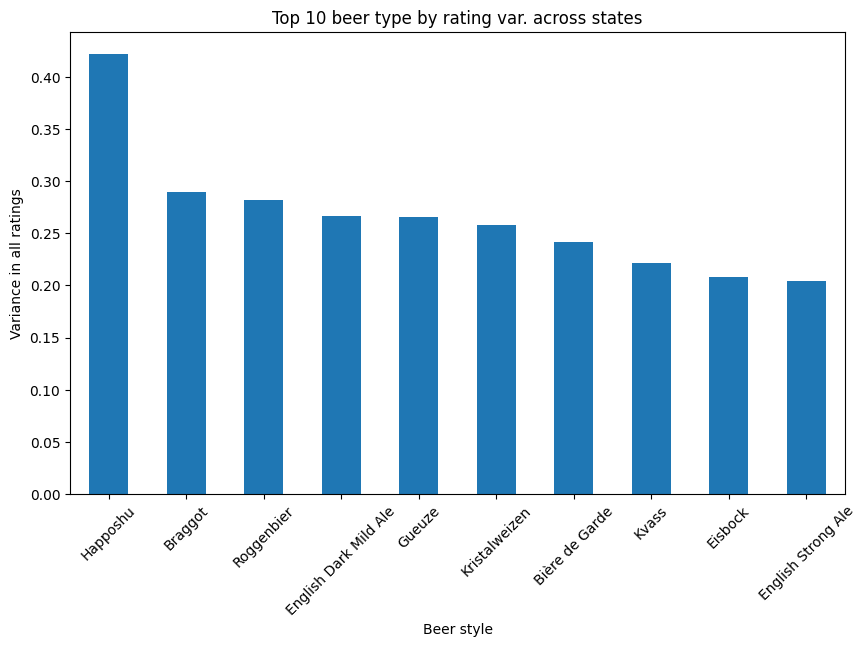

In [9]:
#variance in ratings for each beer style across all states
rating_variance_by_style = reviews_by_beer_state.groupby('style')['overall'].var().sort_values(ascending=False)
print("Beer styles with the highest variance in ratings across states:")
print(rating_variance_by_style.head(10))

# plot top10 by highest var.
plt.figure(figsize=(10, 6))
rating_variance_by_style.head(10).plot(kind='bar')
plt.title('Top 10 beer type by rating var. across states')
plt.xlabel('Beer style')
plt.ylabel('Variance in all ratings')
plt.xticks(rotation=45)
plt.show()


## Correlation of data for global rating

Correlation of criterion with rating by beer style
                                 appearance     aroma    palate     taste  \
Altbier                           -0.078269 -0.063418 -0.045403 -0.032804   
American Adjunct Lager             0.288332  0.317479  0.322582  0.344913   
American Amber / Red Ale           0.062904  0.106254  0.097755  0.104936   
American Amber / Red Lager         0.150192  0.155615  0.151391  0.151476   
American Barleywine               -0.044680 -0.032289 -0.039025 -0.026704   
...                                     ...       ...       ...       ...   
Braggot                            0.113204  0.133813  0.122774  0.158288   
Faro                               0.097795  0.186831  0.156079  0.196818   
Lambic - Unblended                 0.186612  0.153148  0.157018  0.182692   
Bière de Champagne / Bière Brut    0.332704  0.378910  0.391410  0.403145   
Roggenbier                         0.056153  0.077936  0.027464  0.069238   

                        

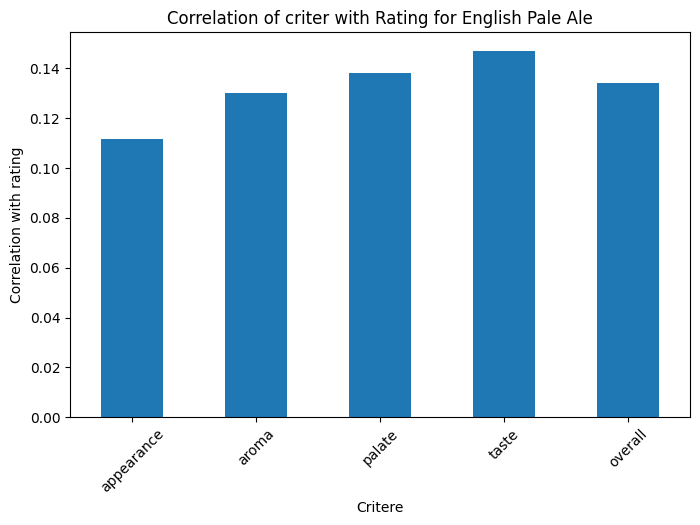

In [10]:
#criterias to analyse corr. with rating
criteria = ['appearance', 'aroma', 'palate', 'taste', 'overall']
criteria_correlation_by_style = {}

for style in beer_styles:
    style_data = reviews_by_beer_state[reviews_by_beer_state['style'] == style]
    if len(style_data) > 20:
        correlations = style_data[criteria + ['rating']].corr()['rating'].drop('rating')
        criteria_correlation_by_style[style] = correlations

criteria_correlation_df = pd.DataFrame(criteria_correlation_by_style)
criteria_correlation_df = criteria_correlation_df.T

print("Correlation of criterion with rating by beer style")
print(criteria_correlation_df)

specific_style = "English Pale Ale"
if specific_style in criteria_correlation_df.index:
    criteria_correlation_df.loc[specific_style].plot(kind='bar', figsize=(8, 5))
    plt.title(f'Correlation of criter with Rating for {specific_style}')
    plt.xlabel('Critere')
    plt.ylabel('Correlation with rating')
    plt.xticks(rotation=45)
    plt.show()



# locality of consumption

In [11]:
def get_ba_beer_merged():
    ba_usa_ratings = pd.read_csv("data/clean/BeerAdvocate/usa_ratings.csv")
    ba_usa_users = pd.read_csv("data/clean/BeerAdvocate/usa_users.csv")

    ba_usa_ratings = ba_usa_ratings.merge(ba_usa_users[['user_id', 'location']], on='user_id', how='left')
    ba_usa_ratings['state'] = ba_usa_ratings['location'].apply(lambda x: x.split(', ')[-1])
    ba_usa_ratings['date'] = ba_usa_ratings['date'].apply(lambda timestamp: datetime.fromtimestamp(timestamp).date())
    # datetime.fromtimestamp(timestamp) 
    return ba_usa_ratings


ba_usa_ratings = get_ba_beer_merged()

,Unnamed: 0,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,...,rating,user_name_nan,abv_nan,appearance_nan,aroma_nan,palate_nan,taste_nan,overall_nan,location,state
0,0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20,nmann08,nmann08.184925,...,2.88,0,0,0,0,0,0,0,"United States, Washington",Washington
1,1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20,StJamesGate,stjamesgate.163714,...,3.67,0,0,0,0,0,0,0,"United States, New York",New York
2,5,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,2014-12-01,Hellpop65,hellpop65.48993,...,3.25,0,0,1,1,1,1,1,"United States, Kansas",Kansas
3,6,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,2014-05-29,Latarnik,latarnik.52897,...,3.50,0,0,1,1,1,1,1,"United States, New Jersey",New Jersey
4,7,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,2014-02-26,RochefortChris,rochefortchris.697017,...,3.50,0,0,1,1,1,1,1,"United States, North Carolina",North Carolina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7303834,8393026,Irvington Pale Ale,19141,Summit Station Restaurant & Brewery,885,American Pale Ale (APA),6.8,2004-11-15,ecoboy,ecoboy.1641,...,3.18,0,0,0,0,0,0,0,"United States, Rhode Island",Rhode Island
7303835,8393027,Kölsch Ale,19139,Summit Station Restaurant & Brewery,885,Kölsch,5.0,2006-02-27,jaluria,jaluria.31362,...,3.80,0,0,0,0,0,0,0,"United States, Connecticut",Connecticut
7303836,8393028,Kölsch Ale,19139,Summit Station Restaurant & Brewery,885,Kölsch,5.0,2006-02-19,Dithyramb,dithyramb.4413,...,2.80,0,0,0,0,0,0,0,"United States, Maryland",Maryland
7303837,8393029,Kölsch Ale,19139,Summit Station Restaurant & Brewery,885,Kölsch,5.0,2004-08-10,ManekiNeko,manekineko.2654,...,1.54,0,0,0,0,0,0,0,"United States, Virginia",Virginia


In [12]:
user_state_dic = {}

for state in pd.unique(ba_usa_ratings['state']):
    user_state_dic[state] = ba_usa_ratings[ba_usa_ratings['state'] == state]

In [13]:
user_state_dic['California'].head()

,Unnamed: 0,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,...,rating,user_name_nan,abv_nan,appearance_nan,aroma_nan,palate_nan,taste_nan,overall_nan,location,state
8,11,Legbiter,19827,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.8,2013-04-25,GraduatedCashew,graduatedcashew.730089,...,3.00,0,0,1,1,1,1,1,"United States, California",California
131,146,St. Patrick's Best,20842,Strangford Lough Brewing Company Ltd,10093,English Bitter,4.2,2010-03-09,Mosstrooper,mosstrooper.235403,...,3.65,0,0,0,0,0,0,0,"United States, California",California
145,187,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,2003-08-04,beerguy101,beerguy101.137,...,2.68,0,0,0,0,0,0,0,"United States, California",California
153,198,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,2002-09-24,zerk,zerk.422,...,3.11,0,0,0,0,0,0,0,"United States, California",California
162,209,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,2001-04-03,Todd,todd.2,...,3.95,0,0,0,0,0,0,0,"United States, California",California


In [14]:
def load_breweries():
    breweries = pd.read_csv("data/clean/BeerAdvocate/breweries.csv")
    breweries['location'] = breweries['location'].apply(lambda x: x.replace('United States, ', ''))
    breweries['state'] = breweries['location'].apply(lambda x: x.split(', ')[-1])
    breweries.loc[breweries['location'].str.contains('Canada, '), 'location'] = 'Canada'
    breweries.loc[breweries['location'].str.contains('United Kingdom, '), 'location'] = 'United Kingdom'
    breweries = breweries.rename(columns={'id': 'brewery_id'})
    
    return breweries



breweries = load_breweries()

breweries.head()

,Unnamed: 0,brewery_id,location,name,nbr_beers,state
0,0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5,Kyrgyzstan
1,1,39913,Kyrgyzstan,Arpa (АРПА),1,Kyrgyzstan
2,2,39914,Kyrgyzstan,Bear Beer,4,Kyrgyzstan
3,3,39915,Kyrgyzstan,Blonder Pub,4,Kyrgyzstan
4,4,39916,Kyrgyzstan,Kellers Bier,2,Kyrgyzstan


In [19]:
def load_user_state_dic(ba_usa_ratings_df, breweries_df):
    user_state_dic = {}

    for state in pd.unique(ba_usa_ratings_df['state']):
        user_state_dic[state] = ba_usa_ratings_df[ba_usa_ratings_df['state'] == state]

    for key in user_state_dic.keys():
        user_state_dic[key] = user_state_dic[key].merge(breweries_df[['brewery_id', 'state']], on='brewery_id', how='left')
        user_state_dic[key] = user_state_dic[key].rename(columns={'state_x': 'user_state', 'state_y': 'brewery_state'})

    return user_state_dic

user_state_dic = load_user_state_dic(ba_usa_ratings, breweries)

In [20]:
def get_provenance_by_state(user_state_dic):
    dic_state_provenance  = {key: {} for key in user_state_dic.keys()}
    for key in user_state_dic.keys():
        dic_state_provenance[key]['local_count'] = user_state_dic[key][user_state_dic[key]['user_state'] == user_state_dic[key]['brewery_state']].shape[0]
        dic_state_provenance[key]['national_count'] = user_state_dic[key][user_state_dic[key]['brewery_state'].isin(user_state_dic.keys() - [key])].shape[0]
        dic_state_provenance[key]['foreign_count'] = user_state_dic[key][~user_state_dic[key]['brewery_state'].isin(user_state_dic.keys())].shape[0]
    return dic_state_provenance

dic_state_provenance = get_provenance_by_state(user_state_dic)

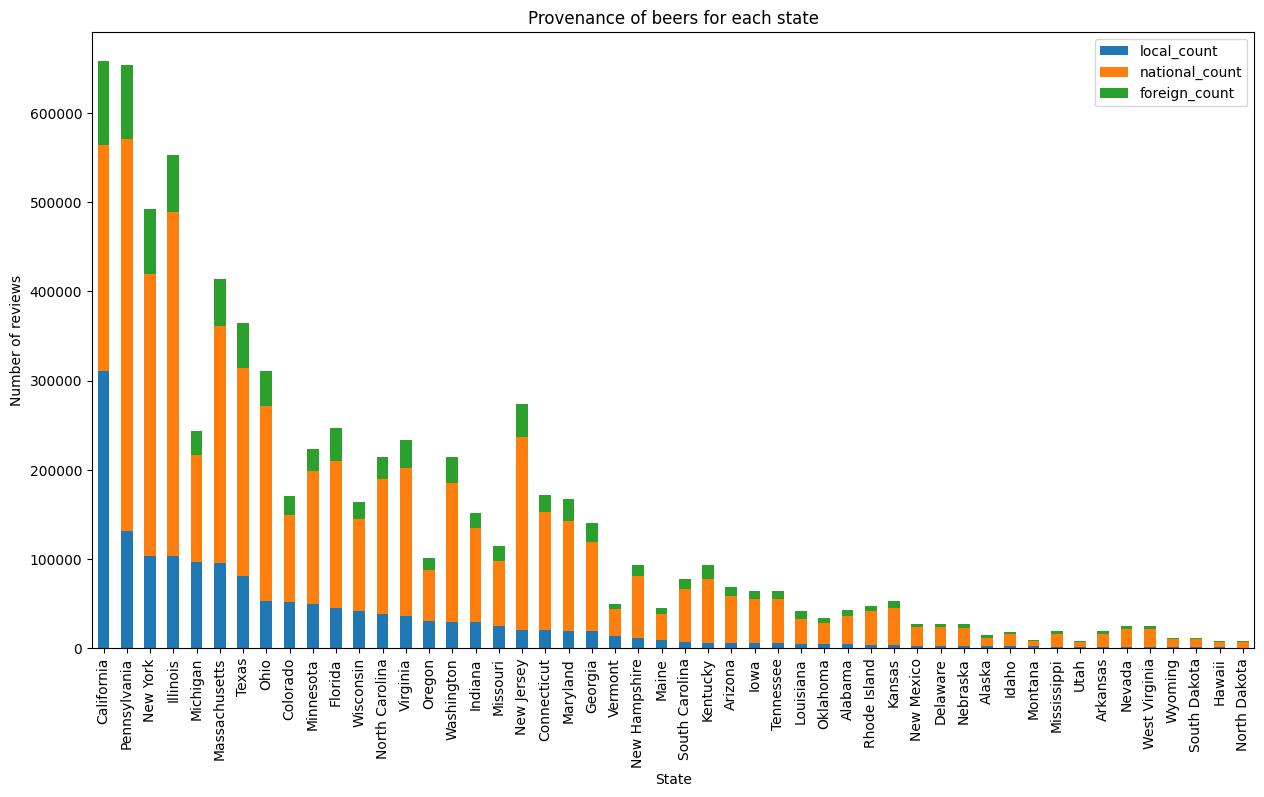

In [21]:
state_provenance_df = pd.DataFrame(dic_state_provenance).T
state_provenance_df = state_provenance_df.sort_values(by='local_count', ascending=False)
state_provenance_df.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Provenance of beers for each state')
plt.xlabel('State')
plt.ylabel('Number of reviews')
plt.show()


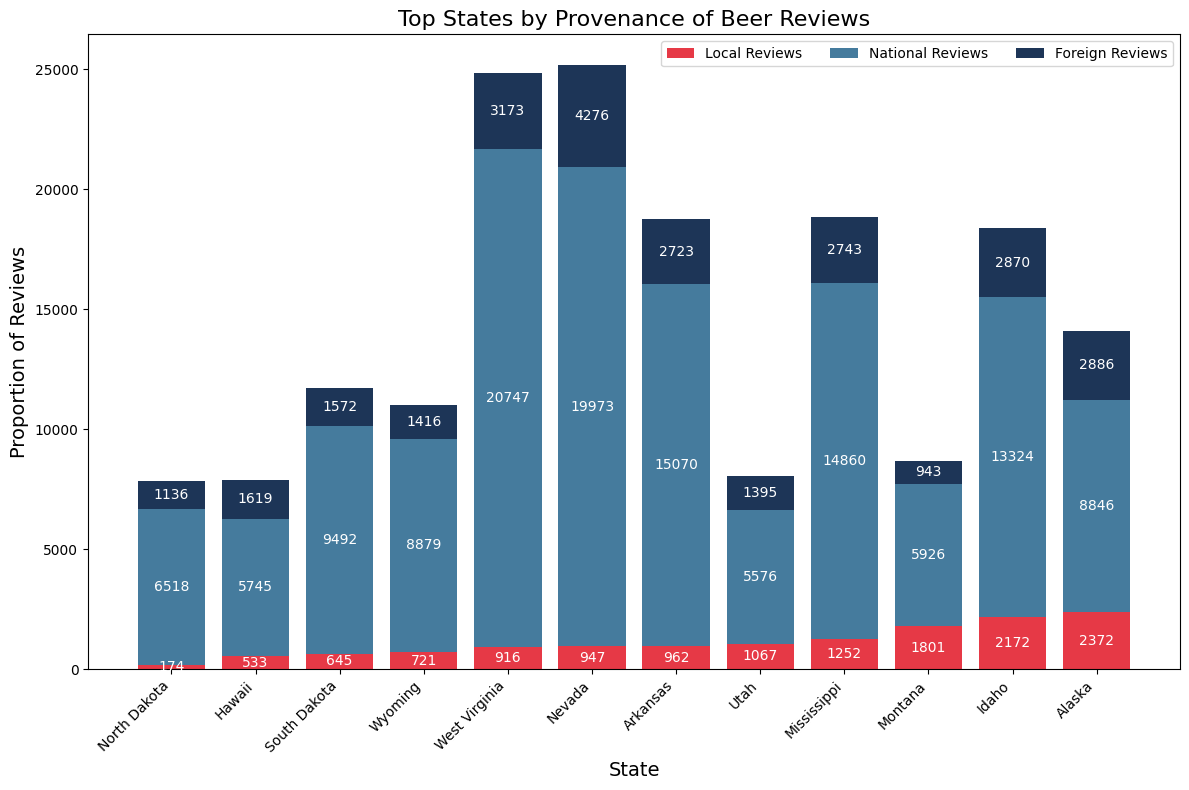

In [30]:
import numpy as np

sort_options = ["local_count", "national_count", "foreign_count", "local_nation_count"]

def top_states_by_provenance(dic_state_provenance, ratio=True):
    
    state_provenance_df = pd.DataFrame(dic_state_provenance).T
    state_provenance_df["total_count"] = state_provenance_df["local_count"] + state_provenance_df["national_count"] + state_provenance_df["foreign_count"]
    state_provenance_df["local_nation_count"] = state_provenance_df["local_count"] + state_provenance_df["national_count"]
    if ratio:
        state_provenance_df["local_count"] = state_provenance_df["local_count"] / state_provenance_df["total_count"]
        state_provenance_df["national_count"] = state_provenance_df["national_count"] / state_provenance_df["total_count"]
        state_provenance_df["local_nation_count"] = state_provenance_df["local_nation_count"] / state_provenance_df["total_count"]
        state_provenance_df["foreign_count"] = state_provenance_df["foreign_count"] / state_provenance_df["total_count"]
    return state_provenance_df

# Generate the stacked bar chart
def plot_stacked_bar_provenance(dic_state_provenance, top_k=10, sort_option="foreign_count", ascending=False, colors=None, width=0.8, ratio=True):
    state_provenance_df = top_states_by_provenance(dic_state_provenance, ratio=ratio)
    state_provenance_df = state_provenance_df.sort_values(by=sort_option, ascending=ascending).head(top_k)
    import matplotlib.pyplot as plt
    
    if colors is None:
        colors = {
            "local_count": "#e63946",
            "national_count": "#457b9d",
            "foreign_count": "#1d3557"
        }
    
    categories = ['local_count', 'national_count', 'foreign_count']
    categories.remove(sort_option)
    categories.insert(0, sort_option)


    if len(colors) != len(categories):
        raise ValueError("The length of colors must match the number of categories.")

    fig, ax = plt.subplots(figsize=(12, 8))
    
    bottom = np.zeros(len(state_provenance_df))
    for idx, category in enumerate(categories):
        p = ax.bar(
            state_provenance_df.index,
            state_provenance_df[category],
            width=width,
            bottom=bottom,
            label=category.replace('_', ' ').replace('count', 'reviews').title(),
            color=colors[category],
        )
        barlabels = ax.bar_label(p, label_type='center', color='white', fmt='{:.2f}' if ratio else "{:.0f}")
        bottom += state_provenance_df[category].values
    
    ax.set_title('Top States by Provenance of Beer Reviews', fontsize=16)
    ax.set_xlabel('State', fontsize=14)
    ax.set_ylabel('Proportion of Reviews', fontsize=14)
    ax.legend(ncols=len(categories),
              loc='lower right' if ratio and not ascending else 'upper right', fontsize='medium')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_stacked_bar_provenance(dic_state_provenance, top_k=12, sort_option="local_count", ascending=True, width=0.8, ratio=False)

In [31]:
ba_usa_ratings_merged = ba_usa_ratings.merge(breweries[['brewery_id', 'state']], on='brewery_id', how='left')
ba_usa_ratings_merged = ba_usa_ratings_merged.rename(columns={'state_x': 'user_state', 'state_y': 'brewery_state'})
ba_usa_ratings_merged = ba_usa_ratings_merged[~ba_usa_ratings_merged["brewery_state"].str.contains("<a href")]
states = ba_usa_ratings_merged[ba_usa_ratings_merged["location"].str.contains("United States,")]["location"].map(lambda x: x.replace("United States, ", "")).unique()

In [53]:
def transform_to_distribution(row):
    if row.sum() <= 0:
        return row
    return row/row.sum()

def get_state_adjacency_matrix(ba_usa_ratings_merged, states, as_ratio=True, drop_world=True):
    state_matrix = ba_usa_ratings_merged.groupby(by=["user_state", "brewery_state"]).size().unstack(fill_value=0)
    foreign_counts = state_matrix.drop(columns=states, errors='ignore').T.sum()
    state_matrix = state_matrix.reindex(index=sorted(list(states)), columns=sorted(list(states)), fill_value=0)
    state_matrix = state_matrix.loc[:, sorted(list(states))]
    if not drop_world:
        state_matrix["World"] = foreign_counts
    if as_ratio:
        state_matrix = state_matrix.apply(transform_to_distribution, axis=1)
    

    
    return state_matrix

state_adj_matrix = get_state_adjacency_matrix(ba_usa_ratings_merged, states, as_ratio=True)
state_adj_matrix

brewery_state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
user_state,,,,,,,,,,,,,,,,,,,,,
Alabama,0.114777,0.002605,0.002209,0.000510,0.173709,0.093679,0.001076,0.018209,0.023646,0.057686,...,0.000170,0.012036,0.018096,0.003653,0.013168,0.004899,0.004588,0.000198,0.027469,0.000425
Alaska,0.000981,0.211446,0.002674,0.000089,0.179800,0.058477,0.002229,0.014441,0.012747,0.007131,...,0.000357,0.000981,0.020681,0.002496,0.022464,0.003209,0.036370,0.000089,0.023355,0.000446
Arizona,0.000225,0.007891,0.101486,0.000277,0.291395,0.113339,0.001800,0.022824,0.011697,0.003963,...,0.000294,0.000900,0.013289,0.009482,0.014449,0.004672,0.013618,0.000087,0.026215,0.000450
Arkansas,0.004616,0.005302,0.003431,0.060005,0.155190,0.116392,0.002183,0.012288,0.012038,0.008296,...,0.000437,0.009044,0.024202,0.004054,0.007922,0.006986,0.007672,0.000187,0.027819,0.000873
California,0.000425,0.007623,0.003815,0.000160,0.550632,0.056703,0.001819,0.015662,0.010859,0.003896,...,0.000152,0.000709,0.009317,0.005784,0.013768,0.002923,0.009670,0.000121,0.014632,0.000500
Colorado,0.000518,0.007072,0.003738,0.000471,0.173770,0.347378,0.001781,0.016779,0.011260,0.005479,...,0.000403,0.001600,0.017377,0.012497,0.013606,0.002783,0.009734,0.000477,0.024039,0.003637
Connecticut,0.000419,0.002070,0.000937,0.000183,0.147888,0.037175,0.135328,0.024884,0.011872,0.004128,...,0.000026,0.001192,0.006755,0.003289,0.078052,0.004724,0.003852,0.000092,0.011453,0.000282
Delaware,0.000501,0.002796,0.000751,0.000417,0.166639,0.050079,0.004006,0.109340,0.022077,0.008138,...,0.000125,0.001127,0.012102,0.004465,0.043903,0.011769,0.007846,0.000459,0.015692,0.000417
Florida,0.001926,0.002880,0.001597,0.000162,0.169103,0.069444,0.002236,0.028356,0.211726,0.029205,...,0.000048,0.002017,0.011606,0.004973,0.022015,0.007038,0.006876,0.000095,0.019206,0.000215


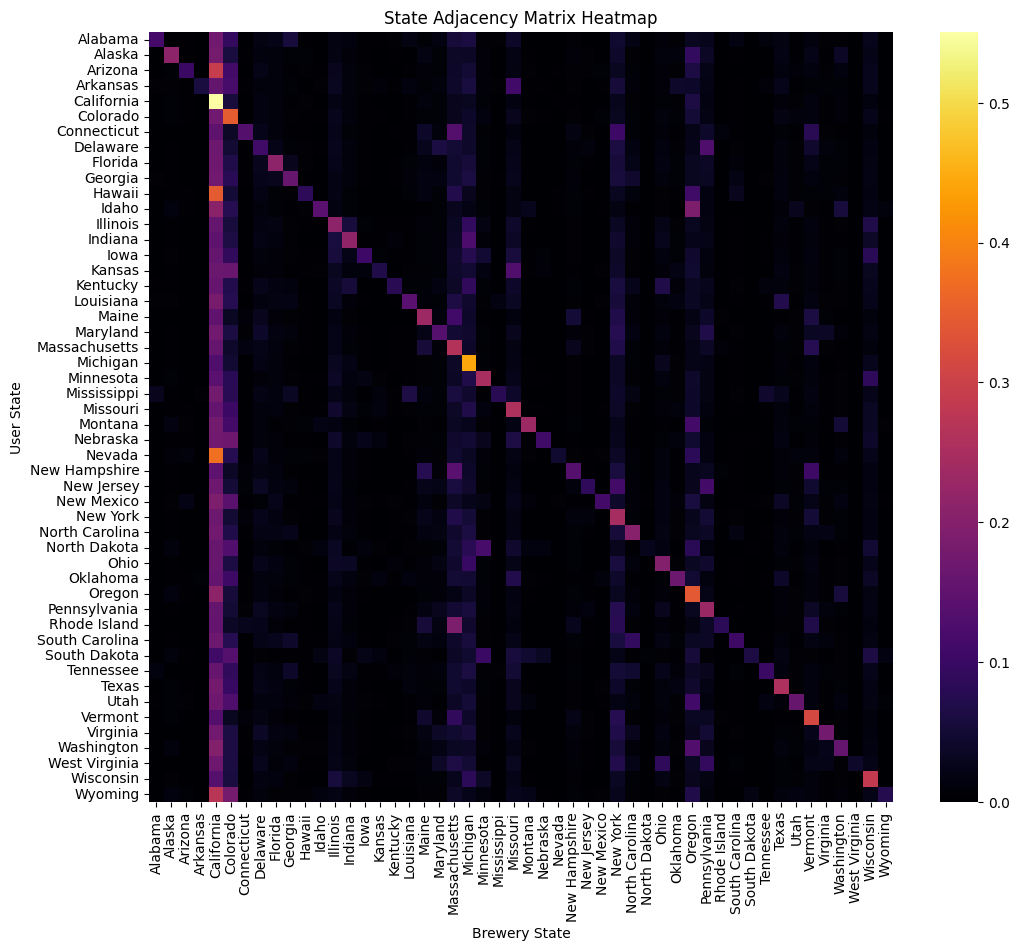

In [98]:
import seaborn as sns
def plot_heatmap(adj_matrix, title, xlabel, ylabel, ax=None):
    if ax:
        sns.heatmap(adj_matrix, cmap='inferno', ax=ax, cbar=False)
        ax.set_title(f"{title}")
    else:
        plt.figure(figsize=(12, 10))
        sns.heatmap(adj_matrix, cmap='inferno') 
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.show()

plot_heatmap(state_adj_matrix, title='State Adjacency Matrix Heatmap', xlabel='Brewery State', ylabel='User State')

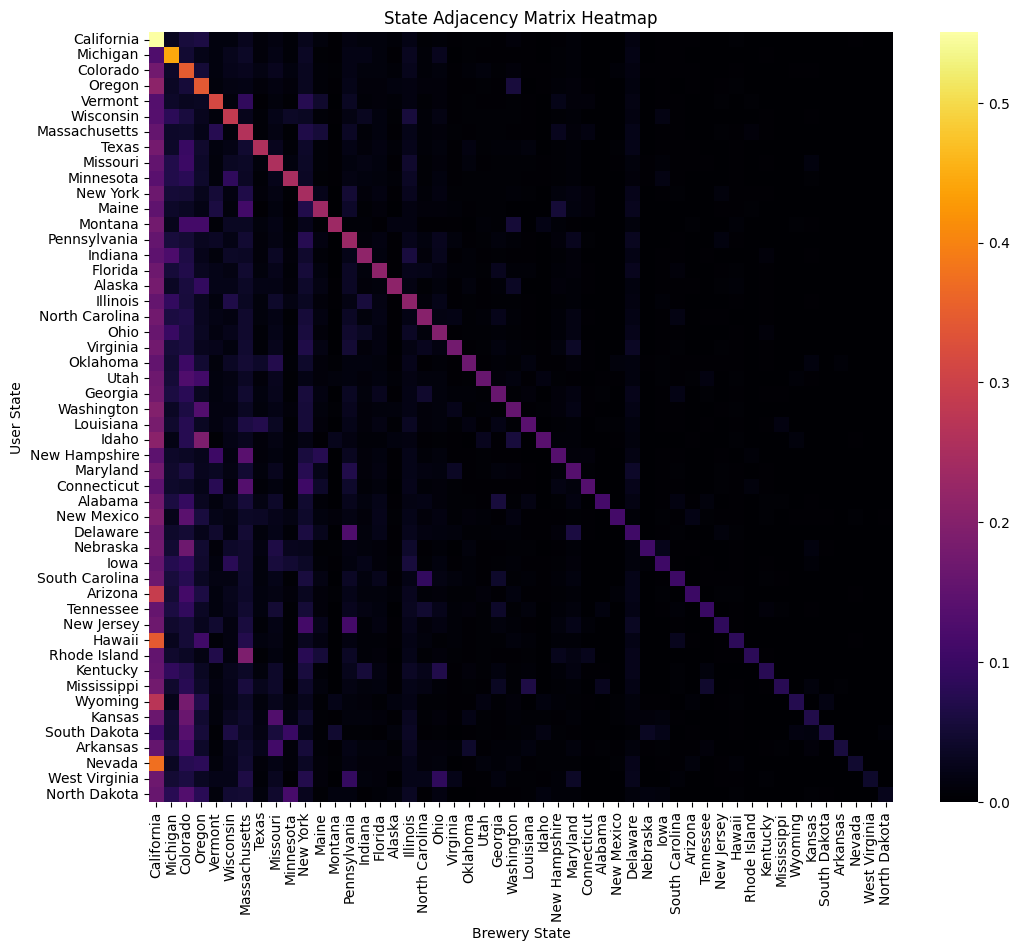

In [94]:
diagonal_values = np.diagonal(state_adj_matrix)
state2diagonal = [(state, diagonal_values[i]) for i, state in enumerate(state_adj_matrix.columns)]
sorted_diagonal = sorted(state2diagonal, reverse=True, key=lambda x: x[1])
sorted_states = [x[0] for x in sorted_diagonal]
sorted_ajd_matrix = state_adj_matrix.loc[sorted_states, sorted_states]

plot_heatmap(sorted_ajd_matrix, title='State Adjacency Matrix Heatmap', xlabel='Brewery State', ylabel='User State')

In [102]:
from matplotlib.animation import FuncAnimation


def get_yearly_reviews(ba_usa_ratings_merged):
    reviews_by_year = ba_usa_ratings_merged.groupby(pd.to_datetime(ba_usa_ratings_merged["date"]).dt.year)
    return reviews_by_year

def create_gif(ba_usa_ratings_merged, states, save_file):
    yearly_reviews = {group: group_df for group, group_df in get_yearly_reviews(ba_usa_ratings_merged)}
    frame2year = {i: group for i, group in enumerate(yearly_reviews.keys())}
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.tight_layout()

    def update(frame):
        year = frame2year[frame]
        data = yearly_reviews[year]
        ax.clear()
        matrix = get_state_adjacency_matrix(data, states, as_ratio=True) 
        plot_heatmap(matrix, title=f'State Adjacency Matrix {year}', xlabel='Brewery State', ylabel='User State', ax=ax)
        fig.tight_layout()
        plt.close(fig)

    anim = FuncAnimation(fig, update, frames=len(frame2year), repeat=True)  
    anim.save(save_file, writer="pillow", fps=2) 

create_gif(ba_usa_ratings_merged, states, "animation.gif")

## Year by year local consumption

In [16]:
#convert cursed date format to normal date
ba_usa_ratings['date'] = pd.to_datetime(ba_usa_ratings['date'])

#separate in months
ba_usa_ratings['year_month'] = ba_usa_ratings['date'].dt.to_period('M')

dic_state_provenance = {key: {} for key in user_state_dic.keys()}


for key in user_state_dic.keys():
    user_state_dic[key]['year_month'] = pd.to_datetime(user_state_dic[key]['date']).dt.to_period('M')


#gather monthly data
for key in user_state_dic.keys():
    
    monthly_data = user_state_dic[key].groupby('year_month')
    dic_state_provenance[key]['local_count'] = monthly_data.apply(lambda x: x[x['user_state'] == x['brewery_state']].shape[0], include_groups=False)
    dic_state_provenance[key]['national_count'] = monthly_data.apply(lambda x: x[x['brewery_state'].isin(user_state_dic.keys() - {key})].shape[0], include_groups=False)
    dic_state_provenance[key]['foreign_count'] = monthly_data.apply(lambda x: x[~x['brewery_state'].isin(user_state_dic.keys())].shape[0], include_groups=False) 
    

In [17]:
cnt = 0
for a in dic_state_provenance['Washington']['local_count'].keys():
    print(a)
    cnt += 1
    if cnt == 20:
        break

2002-10
2002-11
2003-01
2003-02
2003-03
2003-04
2003-05
2003-06
2003-07
2003-08
2003-09
2003-10
2003-11
2003-12
2004-01
2004-02
2004-03
2004-04
2004-05
2004-06


In [18]:
dic_state_provenance['all_states'] = {}

for date_key in dic_state_provenance['Washington']['local_count'].keys():
    date_key_str = str(date_key)
    if date_key_str not in dic_state_provenance['all_states']:
        dic_state_provenance['all_states'][date_key_str] = {
            'local_count': 0,
            'national_count': 0,
            'foreign_count': 0
        }

    #conbine cnts for all states
    for state_key in dic_state_provenance.keys():
        if state_key == 'all_states':
            continue

        dic_state_provenance['all_states'][date_key_str]['local_count'] += dic_state_provenance[state_key]['local_count'].get(date_key, 0)
        dic_state_provenance['all_states'][date_key_str]['national_count'] += dic_state_provenance[state_key].get('national_count', {}).get(date_key, 0)
        dic_state_provenance['all_states'][date_key_str]['foreign_count'] += dic_state_provenance[state_key].get('foreign_count', {}).get(date_key, 0)


In [19]:
dic_state_provenance['all_states']

{'2002-10': {'local_count': np.int64(321),
  'national_count': np.int64(1070),
  'foreign_count': np.int64(917)},
 '2002-11': {'local_count': np.int64(336),
  'national_count': np.int64(1372),
  'foreign_count': np.int64(874)},
 '2003-01': {'local_count': np.int64(473),
  'national_count': np.int64(1537),
  'foreign_count': np.int64(1290)},
 '2003-02': {'local_count': np.int64(375),
  'national_count': np.int64(1628),
  'foreign_count': np.int64(1128)},
 '2003-03': {'local_count': np.int64(424),
  'national_count': np.int64(1829),
  'foreign_count': np.int64(1288)},
 '2003-04': {'local_count': np.int64(405),
  'national_count': np.int64(1652),
  'foreign_count': np.int64(1130)},
 '2003-05': {'local_count': np.int64(373),
  'national_count': np.int64(1837),
  'foreign_count': np.int64(1157)},
 '2003-06': {'local_count': np.int64(412),
  'national_count': np.int64(1876),
  'foreign_count': np.int64(1252)},
 '2003-07': {'local_count': np.int64(509),
  'national_count': np.int64(1926),
  '

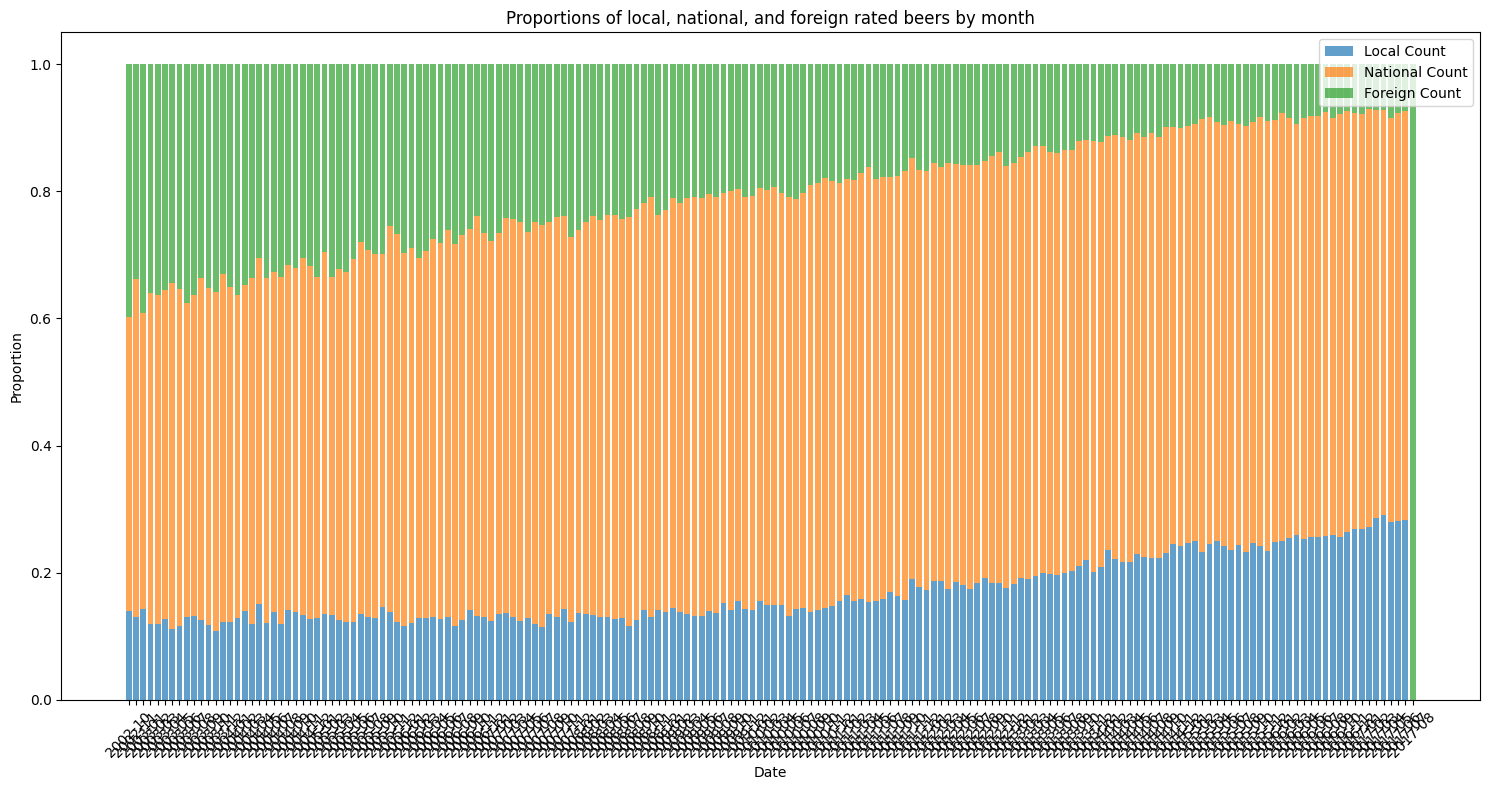

In [20]:
dates = []
local_proportions = []
national_proportions = []
foreign_proportions = []

for date, data in dic_state_provenance['all_states'].items():
    total = data['local_count'] + data['national_count'] + data['foreign_count']
    if total > 0:
        dates.append(date)
        local_proportions.append(data['local_count'] / total)
        national_proportions.append(data['national_count'] / total)
        foreign_proportions.append(data['foreign_count'] / total)

dates, local_proportions, national_proportions, foreign_proportions = zip(
    *sorted(zip(dates, local_proportions, national_proportions, foreign_proportions))
)

plt.figure(figsize=(15, 8))
plt.bar(dates, local_proportions, label='Local Count', alpha=0.7)
plt.bar(dates, national_proportions, bottom=local_proportions, label='National Count', alpha=0.7)
plt.bar(
    dates, foreign_proportions,
    bottom=[i + j for i, j in zip(local_proportions, national_proportions)],
    label='Foreign Count', alpha=0.7
)

plt.xlabel('Date')
plt.ylabel('Proportion')
plt.title('Proportions of local, national, and foreign rated beers by month')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
